# Capstone Hotel reservation prediction

![Logo](img/hotel-logo.png)

## Modelling Repeater
#### (Folgebuchung)

### Import required libraries

In [30]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

#modelling
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

#visualisations
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

import visuals as vs

%matplotlib inline

#### Loading cleaned dataset

In [2]:
df = pd.read_csv("data/dataset_w_feature.csv", index_col=0, encoding="iso-8859-15")

In [3]:
df["buchungsdatum"]      = pd.to_datetime(df["buchungsdatum"])
df["anreisedatum"]       = pd.to_datetime(df["anreisedatum"])
df["abreisedatum"]       = pd.to_datetime(df["abreisedatum"])

In [4]:
df.head()

,buchungsdatum,anreisedatum,abreisedatum,naechte_insgesamt,gebuchte_naechte,personen_anzahl,gesamtpreis,saison,buchung_telefon,buchung_online,buchung_reisebuero,zimmerarten,reise_adventure,reise_relax,reise_standard,reise_genuss,kind,entfernung,zahler,kunden_id,buchungsnr,buchungsnr_reisebuero,menue_code,zusatzleistung,destination,anrede,plz,ort,kundenclub,jahrgangsalter_klassiert,bundesland,einwohner_adjusted_plz,bev_m_plz,bev_w_plz,bev_insgesamt_ort,bev_weiblich_ort,bev_maennlich_ort,qkm_plz,flaeche_ort,einwohnerdichte_prokm2_plz,haushalte_regiog_2017_plz,kaufkraft_einwohner_in_eur_regio,kk_einwohner_index_regiog_2017,kk_hh_index_regiog_2017,gemeindetyp_regiostar_2016,wirtschaftskraftmr1,wirtschaftskraftmr2,buchungsjahr,buchungsquartal,buchungsmonat,buchungswoche,buchungstag,buchung_wochentag,anreisejahr,anreisequartal,anreisemonat,anreisewoche,anreisetag,anreise_wochentag,abreisejahr,abreisequartal,abreisemonat,abreisewoche,abreisetag,abreise_wochentag,buchungsmonat-jahr,buchungsquartal-jahr,anreisemonat-jahr,anreisequartal-jahr,abreisemonat-jahr,abreisequartal-jahr,buchungskanal,werbe_ban,anz_werbe_ban,aufenthalt,naechte_ausserhalb,anz_buch,buchungsvorlauf,preis_per,preis_nacht,preis_nacht_per,VIP,buch_zeilen,erstbuchung,folgebuchung,repeater
0,2010-01-29,2010-04-02,2010-04-10,8,8,2,2982,2010,0,0,1,classic,0,0,0,1,0,535.48,1,1,1151,456,5,5,linz,Herr,29664,Walsrode,0,55-64,Niedersachsen,25173,12540,12633,25173,11577,11491,344.326464,344.326464,73.108,11453,20641.89,92.819,98.104,Landregion - Zentrale Stadt,-0.333392,-0.388738,2010,1,1,4,29,Freitag,2010,2,4,13,2,Freitag,2010,2,4,14,10,Samstag,20101,20101,20104,20102,20104,20102,reisebuero,keine,0,8,0,1,63,1491.00,372.75,186.38,0,2,1,0,0
1,2010-01-14,2010-04-05,2010-04-10,5,5,2,1437,2010,0,0,1,classic,0,0,1,0,0,544.72,0,2,40,6413,5,5,linz,Frau,50226,Frechen,0,55-64,Nordrhein-Westfalen,52473,25645,26828,52473,26828,25645,45.118960,45.118960,1162.992,26227,25268.58,113.623,111.379,Landregion - Zentrale Stadt,0.853802,-0.345112,2010,1,1,2,14,Donnerstag,2010,2,4,14,5,Montag,2010,2,4,14,10,Samstag,20101,20101,20104,20102,20104,20102,reisebuero,generell,5,5,0,1,81,718.50,287.40,143.70,0,2,1,0,0
2,2010-03-01,2010-04-05,2010-04-10,5,5,2,1737,2010,0,0,1,classic,0,0,1,0,0,606.63,0,3,2134,4322,5,5,linz,Herr,23970,Wismar,0,75-84,Mecklenburg-Vorpommern,1423,692,731,46442,21844,20706,50.563027,83.131346,17.117,6355,18697.65,84.076,73.665,"Stadtregion - Kleinstädtischer, dörflicher Raum",-1.012536,-1.012536,2010,1,3,9,1,Montag,2010,2,4,14,5,Montag,2010,2,4,14,10,Samstag,20103,20101,20104,20102,20104,20102,reisebuero,keine,0,5,0,1,35,868.50,347.40,173.70,0,2,1,0,0
3,2010-01-25,2010-03-21,2010-03-25,4,4,2,1047,2010,0,0,1,classic,0,1,0,0,0,421.59,1,4,776,6414,69,9,linz,Frau,15732,Eichwalde,0,65-74,Brandenburg,14690,7302,7388,14690,4135,4087,11.965427,11.965427,1227.704,7159,23442.06,105.410,104.087,Landregion - Städtischer Raum,0.417226,0.417226,2010,1,1,4,25,Montag,2010,1,3,11,21,Sonntag,2010,1,3,12,25,Donnerstag,20101,20101,20103,20101,20103,20101,reisebuero,keine,0,4,0,1,55,523.50,261.75,130.88,0,1,1,0,0
4,2010-01-26,2010-03-07,2010-03-09,2,2,20,5279,2010,0,0,1,classic,1,0,0,0,0,37.88,0,5,813,2938,113,2,duesseldorf,Frau,53881,Euskirchen,1,45-54,Nordrhein-Westfalen,28531,13975,14556,57975,29578,28397,127.679129,139.430913,204.625,11683,23328.82,104.901,120.110,"Stadtregion - Kleinstädtischer, dörflicher Raum",0.212335,-0.579173,2010,1,1,4,26,Dienstag,2010,1,3,9,7,Sonntag,2010,1,3,10,9,Dienstag,20101,20101,20103,20101,20103,20101,reisebuero,keine,0,2,0,1,40,263.95,2639.50,131.98,0,7,1,0,1


## Preparation

#### Dropping redundant variables

In [5]:
df.drop("buchungskanal", axis=1, inplace=True)
df.drop("werbe_ban", axis=1, inplace=True)

#### Grouping variables

In [6]:
categorial = list(df.columns[df.dtypes==object])
datetime64 = ['buchungsdatum', 'anreisedatum', 'abreisedatum']
numeric    = list(df.select_dtypes(include=['int64', 'float64']).columns)

#to prevent data leakage
for entry in ['erstbuchung', 'repeater', 'kunden_id', 'folgebuchung', 'menue_code', 'zusatzleistung', 'plz', 'kundenclub', 'anz_buch']: 
    numeric.remove(entry)
    
for entry in ['menue_code', 'zusatzleistung']: 
    categorial.append(entry)    

categorial.remove('ort')

# 8 = erstbuchung, repeater, kunden_id, folgebuchung, plz, kundenclub, anz_buch, ort
df.shape[1] == len(categorial) + len(datetime64) + len(numeric) + 8

True

#### renaming destinations

In [7]:
aenderung = { "saint etienne": "saint-etienne",
              "viana do castelo": "viana-do-castelo",
            }

df.destination.replace(aenderung, inplace=True)

aenderung2 = {
"Landregion - Kleinstädtischer, dörflicher Raum": "Kleinstädt_(Land)",
"Landregion - Städtischer Raum": "Stadt_(Land)",
"Landregion - Zentrale Stadt": "zen_Stadt_(Land)",
"Stadtregion - Kleinstädtischer, dörflicher Raum": "Kleinstädt_(Stadt)",
"Stadtregion - Metropole": "Metropole",
"Stadtregion - Mittelstadt, städtischer Raum": "Mittelstadt",
"Stadtregion -Regiopole und Großstadt": "Regiopole"
    }

df.gemeindetyp_regiostar_2016.replace(aenderung2, inplace=True)

In [8]:
df.menue_code     = df.menue_code.astype("str")
df.zusatzleistung = df.zusatzleistung.astype("str")

### Normalisation and dummy encoding

In [9]:
df = df.reset_index()
x = df[numeric]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
columns = df[numeric].columns
df_num = pd.DataFrame(x_scaled)
df_num.columns = columns

df_dum = pd.get_dummies(df[categorial])
df_dum.shape

(196989, 283)

## Logistic Regression
Basic (only numeric features)

In [10]:
model, acc, pre, rec, f1, roc = [], [], [], [], [], []

In [11]:
X = df[numeric]
y = df.folgebuchung

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

lr1 = LogisticRegression(solver='liblinear', max_iter=10_000, random_state=1337)

y_pred1 = cross_val_predict(lr1, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("Basic Logistic Regression")
acc.append(accuracy_score(y, y_pred1)*100)
pre.append(precision_score(y, y_pred1)*100)
rec.append(recall_score(y, y_pred1)*100)
f1.append(f1_score(y, y_pred1)*100)
#roc1 = roc_curve(y, y_pred1)*100
roc.append(roc_auc_score(y, y_pred1)*100) #ändern test oder train?

conf_matrix1 = confusion_matrix(y, y_pred1)
class_rep1 = classification_report(y, y_pred1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   26.4s remaining:   39.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   28.1s finished


only numeric features but normalised

In [12]:
X = df_num
y = df.folgebuchung

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle = True, stratify = y)

lr2 = LogisticRegression(solver='liblinear', max_iter=10_000, random_state=1337)

y_pred2 = cross_val_predict(lr2, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("Normalised Logistic Regression")
acc.append(accuracy_score(y, y_pred2)*100)
pre.append(precision_score(y, y_pred2)*100)
rec.append(recall_score(y, y_pred2)*100)
f1.append(f1_score(y, y_pred2)*100)
#roc2 = roc_curve(y, y_pred2)*100
roc.append(roc_auc_score(y, y_pred2)*100)

conf_matrix2 = confusion_matrix(y, y_pred2)
class_rep2 = classification_report(y, y_pred2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.3s remaining:   19.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   14.2s finished


### extended Logistic Regression
(categorial variables as dummies)

In [13]:
X = pd.concat([df_num, df_dum], axis=1)
y = df.folgebuchung

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)

lr3 = LogisticRegression(solver='liblinear', max_iter=10_000, random_state=1337)

y_pred3 = cross_val_predict(lr3, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("Logistic Regression (w. dummies)")
acc.append(accuracy_score(y, y_pred3)*100)
pre.append(precision_score(y, y_pred3)*100)
rec.append(recall_score(y, y_pred3)*100)
f1.append(f1_score(y, y_pred3)*100)
#roc3 = roc_curve(y, y_pred3)*100
roc.append(roc_auc_score(y, y_pred3)*100)

conf_matrix3 = confusion_matrix(y, y_pred3)
class_rep3 = classification_report(y, y_pred3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   25.5s remaining:   38.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.4s finished


### Dealing with imbalace 
in target feature folgebuchung by resampling

In [14]:
df.folgebuchung.value_counts()

0    157855
1     39134
Name: folgebuchung, dtype: int64

New train/test split without normalisation

In [15]:
X = pd.concat([df[numeric], df_dum], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

#### Upsampling

In [16]:
# concatenate our training data back together
X = pd.concat([X, y], axis=1)

# separate minority and majority classes
erstbuchung  = X[X.folgebuchung==0]
folgebuchung = X[X.folgebuchung==1]

# upsample minority
folgebuchung_upsampled = resample(folgebuchung, replace=True, 
                          n_samples=len(erstbuchung), # match number in majority class
                          random_state=1337) 

# combine majority and upsampled minority
upsampled = pd.concat([erstbuchung, folgebuchung_upsampled])

upsampled.folgebuchung.value_counts()

1    157855
0    157855
Name: folgebuchung, dtype: int64

#### Downsampling

In [18]:
# downsample majority
erstbuchung_downsampled = resample(erstbuchung, replace=False, 
                          n_samples=len(folgebuchung), # match minority n
                          random_state=1337) 

# combine majority and upsampled minority
downsampled = pd.concat([folgebuchung, erstbuchung_downsampled])

downsampled.folgebuchung.value_counts()

1    39134
0    39134
Name: folgebuchung, dtype: int64

### balanced Logistic Regression
with upsampled data and additional dummy variables

In [19]:
y = upsampled.folgebuchung
X = upsampled.drop('folgebuchung', axis=1)

lr4 = LogisticRegression(solver='liblinear', max_iter=10_000, n_jobs=-1, random_state=1337)

y_pred4 = cross_val_predict(lr4, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("Balanced Logistic Regression (upsampled)")
acc.append(accuracy_score(y, y_pred4)*100)
pre.append(precision_score(y, y_pred4)*100)
rec.append(recall_score(y, y_pred4)*100)
f1.append(f1_score(y, y_pred4)*100)
#roc4 = roc_curve(y, y_pred4)*100
roc.append(roc_auc_score(y, y_pred4)*100)

conf_matrix4 = confusion_matrix(y, y_pred4)
class_rep4 = classification_report(y, y_pred4)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


### 2nd balanced Logistic Regression
downsampled

In [20]:
y = downsampled.folgebuchung
X = downsampled.drop('folgebuchung', axis=1)

lr5 = LogisticRegression(solver='liblinear', max_iter=10_000, n_jobs=-1, random_state=1337)

y_pred5 = cross_val_predict(lr5, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("Balanced Logistic Regression (downsampled)")
acc.append(accuracy_score(y, y_pred5)*100)
pre.append(precision_score(y, y_pred5)*100)
rec.append(recall_score(y, y_pred5)*100)
f1.append(f1_score(y, y_pred5)*100)
#roc5 = roc_curve(y, y_pred5)*100
roc.append(roc_auc_score(y, y_pred5)*100)

conf_matrix5 = confusion_matrix(y, y_pred5)
class_rep5 = classification_report(y, y_pred5)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.2s remaining:   31.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   27.7s finished


## Advanced models
## Random forest
fixed settings after reandom search

In [21]:
X = pd.concat([df[numeric], df_dum], axis=1)
y = df.folgebuchung

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

lr6 = RandomForestClassifier(n_estimators= 120, min_samples_split= 5,
                             min_samples_leaf= 6, max_features= None,
                             max_depth= None, random_state= 1337)

y_pred6 = cross_val_predict(lr6, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("Random Forest")
acc.append(accuracy_score(y, y_pred6)*100)
pre.append(precision_score(y, y_pred6)*100)
rec.append(recall_score(y, y_pred6)*100)
f1.append(f1_score(y, y_pred6)*100)
#roc6 = roc_curve(y, y_pred6)*100
roc.append(roc_auc_score(y, y_pred6)*100)

conf_matrix6 = confusion_matrix(y, y_pred6)
class_rep6 = classification_report(y, y_pred6)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 28.5min remaining: 42.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 29.3min finished


### GaussianNB

In [23]:
X = pd.concat([df[numeric], df_dum], axis=1)
y = df.folgebuchung

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1337)

lr7 = GaussianNB()

y_pred7 = cross_val_predict(lr7, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("GaussianNB")
acc.append(accuracy_score(y, y_pred7)*100)
pre.append(precision_score(y, y_pred7)*100)
rec.append(recall_score(y, y_pred7)*100)
f1.append(f1_score(y, y_pred7)*100)
#roc7 = roc_curve(y, y_pred7)*100
roc.append(roc_auc_score(y, y_pred7)*100)

conf_matrix7 = confusion_matrix(y, y_pred7)
class_rep7 = classification_report(y, y_pred7)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.5s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.6s finished


### KNeighborsClassifier

In [25]:
lr8 = KNeighborsClassifier(n_neighbors=3)

y_pred8 = cross_val_predict(lr8, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("KNeighborsClassifier")
acc.append(accuracy_score(y, y_pred8)*100)
pre.append(precision_score(y, y_pred8)*100)
rec.append(recall_score(y, y_pred8)*100)
f1.append(f1_score(y, y_pred8)*100)
#roc8 = roc_curve(y, y_pred8)*100
roc.append(roc_auc_score(y, y_pred8)*100)

conf_matrix8 = confusion_matrix(y, y_pred8)
class_rep8 = classification_report(y, y_pred8)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.2min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.2min finished


### DecisionTreeClassifier

In [27]:
lr9 = DecisionTreeClassifier(random_state=1337)

y_pred9 = cross_val_predict(lr9, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("DecisionTreeClassifier")
acc.append(accuracy_score(y, y_pred9)*100)
pre.append(precision_score(y, y_pred9)*100)
rec.append(recall_score(y, y_pred9)*100)
f1.append(f1_score(y, y_pred9)*100)
#roc9 = roc_curve(y, y_pred9)*100
roc.append(roc_auc_score(y, y_pred9)*100)

conf_matrix9 = confusion_matrix(y, y_pred9)
class_rep9 = classification_report(y, y_pred9)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   17.5s remaining:   26.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.2s finished


### AdaBoost

In [28]:
lr10 = AdaBoostClassifier(DecisionTreeClassifier(random_state=1337))

y_pred10 = cross_val_predict(lr10, X, y, cv=5, n_jobs=-1, verbose=5)

model.append("AdaBoost")
acc.append(accuracy_score(y, y_pred10)*100)
pre.append(precision_score(y, y_pred10)*100)
rec.append(recall_score(y, y_pred10)*100)
f1.append(f1_score(y, y_pred10)*100)
#roc10 = roc_curve(y, y_pred10)*100
roc.append(roc_auc_score(y, y_pred10)*100)

conf_matrix10 = confusion_matrix(y, y_pred10)
class_rep10 = classification_report(y, y_pred10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 13.4min remaining: 20.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 14.9min finished


## Model comparsion

### Naive Predictor Performace

What if we chose a model that always predicted an individual as repeater, what would that model's accuracy, precision, recall and F-score be on this dataset?

In [32]:
# Calculate accuracy
fol_c = df.query("folgebuchung == 1").count()[0]
n_fol_c = df.query("folgebuchung == 0").count()[0]
accuracy = fol_c / df.shape[0]

# Calculating precision
precision = fol_c / (fol_c + n_fol_c)

#Calculating recall
recall = fol_c / (fol_c + 0)

# Calculate F-score using the formula above for beta = 0.5
fscore =  (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print (f"Naive Predictor:\n\tAccuracy score:\t{accuracy*100:.2f}\n\tPrecision score:{precision*100:.2f}\n\tRecall score:\t{recall*100:.2f}\n\tF-score:\t{fscore*100:.2f}")

Naive Predictor:
	Accuracy score:	19.87
	Precision score:19.87
	Recall score:	100.00
	F-score:	23.66


#### Confusion Matrix & Classification Report
<img src="img/conf_matrix.png" alt="Drawing" style="width: 400px;"/>

In [33]:
for entry in range(0,len(acc)):
    print(f"Model{entry+1} {model[entry]}:\n\tAccuracy:\t{round(acc[entry],2)}")
    print(f"\tPrecision:\t{round(pre[entry],2)}")
    print(f"\tRecall:\t\t{round(rec[entry],2)}")
    print(f"\tF1:\t\t{round(f1[entry],2)}")
    print(f"\tROC AUC:\t{round(roc[entry],2)}\n\n")

Model1 Basic Logistic Regression:
	Accuracy:	78.13
	Precision:	25.9
	Recall:		5.43
	F1:		8.98
	ROC AUC:	50.79


Model2 Normalised Logistic Regression:
	Accuracy:	79.68
	Precision:	47.03
	Recall:		18.16
	F1:		26.2
	ROC AUC:	56.54


Model3 Logistic Regression (w. dummies):
	Accuracy:	79.59
	Precision:	47.53
	Recall:		26.23
	F1:		33.8
	ROC AUC:	59.52


Model4 Balanced Logistic Regression (upsampled):
	Accuracy:	58.99
	Precision:	58.24
	Recall:		63.51
	F1:		60.76
	ROC AUC:	58.99


Model5 Balanced Logistic Regression (downsampled):
	Accuracy:	59.82
	Precision:	59.97
	Recall:		59.04
	F1:		59.5
	ROC AUC:	59.82


Model6 Random Forest:
	Accuracy:	64.51
	Precision:	27.18
	Recall:		46.82
	F1:		34.39
	ROC AUC:	57.86


Model7 GaussianNB:
	Accuracy:	60.65
	Precision:	24.8
	Recall:		48.26
	F1:		32.76
	ROC AUC:	55.99


Model8 KNeighborsClassifier:
	Accuracy:	61.41
	Precision:	22.55
	Recall:		38.74
	F1:		28.51
	ROC AUC:	52.88


Model9 DecisionTreeClassifier:
	Accuracy:	63.88
	Precision:	28.07
	Recall:	

## Best results

In [34]:
print("LR6 Random Forest\n")
print(conf_matrix10)
print(f"\n{class_rep10}")

LR6 Random Forest

[[122148  35707]
 [ 19668  19466]]

              precision    recall  f1-score   support

           0       0.86      0.77      0.82    157855
           1       0.35      0.50      0.41     39134

    accuracy                           0.72    196989
   macro avg       0.61      0.64      0.61    196989
weighted avg       0.76      0.72      0.74    196989



### Feature Importance

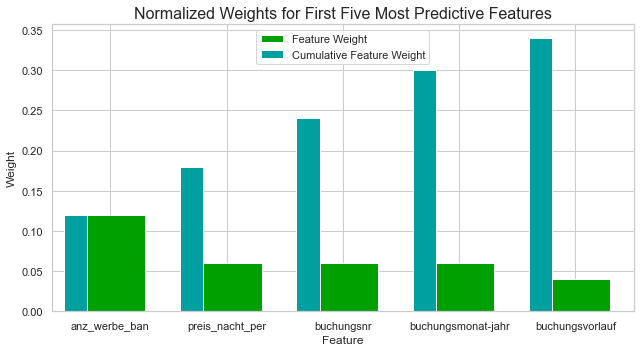

In [36]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier().fit(X,y)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X, y)

There are 38 features with importance, the first four have cumulative feature weight of 30%, each additional adds 2 more percent